# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [1]:
import utils  # a python module in the same dir as the notebooks
import seaborn as sns

In [2]:
CORPUS_NAME = 'genia'
MODEL_NAME = CORPUS_NAME + ''
MODEL_SPEC = '_min2_l10'
FREQ_THRESHOLD = 4

INCLUDE_MESH_TERMS = True
FILTER_STOP_WORDS = True
FILTER_PUNCTUATION = True

In [3]:
import os
os.chdir(utils.ROOT)  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpus
print('Loading n-gram model', flush=True)
model = ngramcounting.NgramModel.load_model(MODEL_NAME, MODEL_SPEC)

if CORPUS_NAME.lower() == 'pmc':
    corpus = dataio.load_craft_corpus() + dataio.load_genia_corpus()
else:
    corpus = dataio.load_corpus(CORPUS_NAME.lower())

Loading n-gram model
Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:13<00:00, 115.46it/s]


## Question 1: How strong is the association in regular concepts?

In [4]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [5]:
len(cont_concepts)

22620

In [6]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [7]:
if INCLUDE_MESH_TERMS:
    concept_bigrams.update(
    {bigram for concept in dataio.load_mesh_terms()
     for bigram in nltk.bigrams(concept)}
    )
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    concept_bigrams = {bg for bg in concept_bigrams
                      if not (bg[0] in punct or bg[1] in punct)}

Loading MeSH terms ...


In [8]:
import pandas as pd
import math

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [9]:
sum(data.freq)

250767

In [10]:
# number of bigram types:
print('Outside:', len(data[data['in_concept'] == False]))
print('Inside:', len(data[data['in_concept'] == True]))

Outside: 11735
Inside: 3311


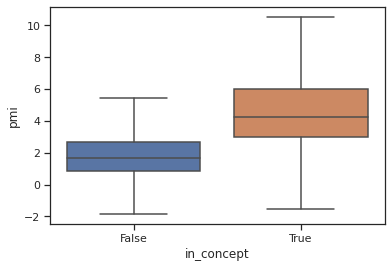

In [11]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

In [12]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=-1.88, lower quartile=0.85, median=1.64, upper quartile=2.59, upper whisker=5.43}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.55, lower quartile=2.98, median=4.23, upper quartile=6.00, upper whisker=10.55}] coordinates {};
\end{axis}


In [13]:
data[(data['in_concept'] == True)].sort_values('pmi', ascending=False).tail(10)
#  & (data['pmi'] < 0)

,bigram,in_concept,pmi,ll,freq
9067,"(protein, gene)",True,-0.831057,6.572340,6
3513,"(activate, cell)",True,-0.841367,6.801217,6
7306,"(transcription, protein)",True,-0.868409,5.192191,4
11702,"(factor, protein)",True,-0.954568,6.487292,4
275,"(activation, gene)",True,-0.989281,7.063973,4
8261,"(cell, activity)",True,-1.141170,16.079193,7
11649,"(cell, transcription)",True,-1.344336,27.278594,8
10998,"(cell, factor)",True,-1.548278,35.030178,7
2217,"(cell, protein)",True,-1.780015,44.790608,6
6214,"(cell, gene)",True,-1.894770,53.423161,6


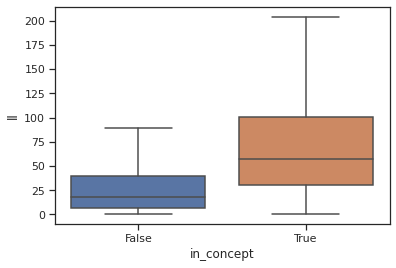

In [14]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [15]:
print(utils.prepare_comparable_latex_boxplots('in_concept', 'll', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2}, xticklabels={False, True}]
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=5.42, median=14.97, upper quartile=30.32, upper whisker=89.54}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=28.20, median=50.87, upper quartile=84.06, upper whisker=203.99}] coordinates {};
\end{axis}


In [16]:
data[(data['in_concept'] == True)].sort_values('ll', ascending=False).tail(10)

,bigram,in_concept,pmi,ll,freq
6930,"(activate, gene)",True,0.107591,0.078955,6
3585,"(expression, study)",True,0.074766,0.033017,5
10108,"(stimulate, cell)",True,0.063665,0.024269,5
6853,"(b, level)",True,0.058358,0.020222,5
880,"(cell, nuclear)",True,-0.028405,0.014129,16
10130,"(beta, cell)",True,-0.050559,0.013239,4
11361,"(receptor, activation)",True,0.038634,0.011897,7
1182,"(level, expression)",True,0.042130,0.010596,5
12377,"(cell, signaling)",True,-0.026216,0.004238,5
13762,"(factor, activation)",True,0.012137,0.001631,10


In [17]:
# we can perform t-tests etc.
import pingouin

In [18]:
pingouin.ttest(list(data[data['in_concept'] == True]['pmi']),
               list(data[data['in_concept'] == False]['pmi']),
               tail='greater',
               correction=True)

/home/kasper/.local/lib/python3.6/site-packages/pingouin/bayesian.py:151: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,64.294,4279.98,greater,0.0,"[2.64, inf]",1.53,inf,1.0


In [19]:
pingouin.mwu(list(data[data['in_concept'] == True]['pmi']),
             list(data[data['in_concept'] == False]['pmi']))

,U-val,tail,p-val,RBC,CLES
MWU,32888081.0,two-sided,0.0,-0.693,0.846


In [20]:
pingouin.ttest(list(data[data['in_concept'] == True]['ll']),
               list(data[data['in_concept'] == False]['ll']),
               tail='greater',
               correction=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,10.029,4054.35,greater,1.060333e-23,"[49.98, inf]",0.254,2.428e+20,1.0


In [21]:
pingouin.mwu(list(data[data['in_concept'] == True]['ll']),
             list(data[data['in_concept'] == False]['ll']))

,U-val,tail,p-val,RBC,CLES
MWU,29654185.0,two-sided,0.0,-0.526,0.763


Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [22]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries and filtered out 0 with the POS-tag filter: None


In [23]:
if FILTER_STOP_WORDS:
    stopwords = set(nltk.corpus.stopwords.words('english'))
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in stopwords or bg[1] in stopwords)}
if FILTER_PUNCTUATION:
    import string
    punct = string.punctuation
    dc_bigrams = {bg for bg in dc_bigrams
                  if not (bg[0] in punct or bg[1] in punct)}

In [24]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    
    data_dict['type'].append(bigram_type)


data = pd.DataFrame(data_dict)

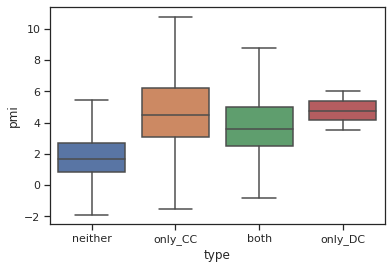

In [25]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [31]:
print(utils.prepare_comparable_latex_boxplots('type', 'pmi', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3, 4}, xticklabels={neither, only_DC, only_CC, both}]
\addplot+ [boxplot prepared={lower whisker=-1.88, lower quartile=0.85, median=1.64, upper quartile=2.59, upper whisker=5.43}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=3.51, lower quartile=4.14, median=4.76, upper quartile=5.39, upper whisker=6.02}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-1.55, lower quartile=3.11, median=4.45, upper quartile=6.20, upper whisker=10.76}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=-0.84, lower quartile=2.51, median=3.57, upper quartile=4.97, upper whisker=8.76}] coordinates {};
\end{axis}


In [33]:
pingouin.kruskal(data, 'pmi', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,3,3749.289,0.0


In [39]:
pingouin.ttest(list(data[data['type'] == 'only_CC']['pmi']),
               list(data[data['type'] == 'both']['pmi']))

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,9.653,920.23,two-sided,4.558043e-21,"[0.71, 1.07]",0.398,3.415e+18,1.0


In [41]:
pingouin.mwu(utils.iqr_outlier_filter(utils.filtered_dist(data, 'pmi', 'type', 'only_CC')),
               utils.iqr_outlier_filter(utils.filtered_dist(data, 'pmi', 'type', 'both')))

,U-val,tail,p-val,RBC,CLES
MWU,944894.5,two-sided,2.707620e-19,-0.241,0.621


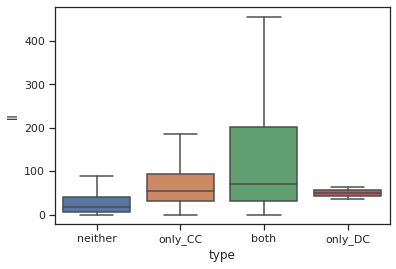

In [26]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [32]:
print(utils.prepare_comparable_latex_boxplots('type', 'll', data))

\begin{axis}[boxplot/draw direction=y, xtick={1, 2, 3, 4}, xticklabels={neither, only_DC, only_CC, both}]
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=5.42, median=14.95, upper quartile=30.31, upper whisker=89.35}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=35.97, lower quartile=42.61, median=49.25, upper quartile=55.89, upper whisker=62.52}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=28.58, median=50.53, upper quartile=82.02, upper whisker=185.24}] coordinates {};
\addplot+ [boxplot prepared={lower whisker=0.00, lower quartile=27.99, median=59.58, upper quartile=127.07, upper whisker=455.59}] coordinates {};
\end{axis}


,Source,ddof1,H,p-unc
Kruskal,type,3,3749.289,0.0


In [28]:
# However, notice that
len(data[data['type'] == 'only_DC'])

2

In [29]:
# compared to e.g.
len(data[data['type'] == 'both'])

563

## Question 3: What is the association across the gap?

In [42]:
from collections import defaultdict
from itertools import product

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_tokens()
    norm_concept = dc.normalized_concept()
    spanned_tokens = dc.get_spanned_tokens()
    non_dc_tokens = set(spanned_tokens).difference(tokens)
    for t in non_dc_tokens:
        if t.mapped_pos() == 'c':
            cc = t
            break
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)

        else:
            cont_bigrams[bigram].append(dc)

In [43]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'type': [], 'in_concept': []}

all_bigrams = set.union(set(gap_bigrams.keys()), set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    data_dict['freq'].append(model.freq(bigram))

    contingency_table = model.contingency_table(bigram[0], bigram[1], smoothing=1)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    elif bigram in cont_bigrams:
        type_ = 'only_cont'
    else:
        type_ = 'weird'

    data_dict['type'].append(type_)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)

data = pd.DataFrame(data_dict)

### NOTE

That a bigram occurs as `only_gap` means that it occurs only in gap position for DC's. However, those bigrams can just as well occur in CC's as well, thereby getting a high association.

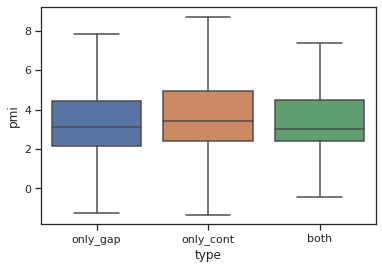

In [44]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

In [50]:
len(data[data['type'] == 'only_gap'])

239

In [46]:
pingouin.kruskal(data, 'pmi', 'type')

,Source,ddof1,H,p-unc
Kruskal,type,2,4.638,0.098361


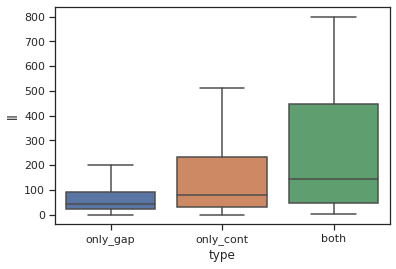

In [47]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

## Question 4: What is the full-term unithood?

In [ ]:
all_concepts = disc_concepts.union(cont_concepts)

In [ ]:
data_dict = {'concept': [], 'type': [],  'pmi_nl': [], 'tc': [], 'freq': [], 'len': []}

for concept in all_concepts:
    
    if model[concept] < FREQ_THRESHOLD:
        continue
    
    data_dict['concept'].append(concept)
    
    data_dict['freq'].append(model[concept])
    
    if concept in disc_concepts:
        if concept in cont_concepts:
            concept_type = 'both'
        else:
            concept_type = 'only_DC'
    else:
        concept_type = 'only_CC'
    data_dict['type'].append(concept_type)
    
    data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(concept, model))
    data_dict['tc'].append(conceptstats.term_coherence(concept, model))
    
    data_dict['len'].append(len(concept))


data = pd.DataFrame(data_dict)

In [ ]:
data.sort_values('tc', ascending=False).head(50)

In [ ]:
len(data[(data['pmi_nl'] < 2) & (data['len'] == 2)]) / len(data)

In [ ]:
sns.boxplot(x='type', y='pmi_nl', data=data, showfliers=False)

In [ ]:
data_dict = {'ngram': [], 'freq': [], 'type': [], 'tc': [], 'pmi_nl': [], 'len': []}

for n in range(2, 11):
    for ngram, count in model.iterate(n, FREQ_THRESHOLD):
        
        ngram = tuple(ngram.split())

        data_dict['ngram'].append(ngram)

        data_dict['freq'].append(model[ngram])

        if ngram in disc_concepts:
            if ngram in cont_concepts:
                ngram_type = 'both'
            else:
                ngram_type = 'only_DC'
        elif ngram in cont_concepts:
            ngram_type = 'only_CC'
        else:
            ngram_type = 'neither'
            
        data_dict['type'].append(ngram_type)

        data_dict['pmi_nl'].append(conceptstats.length_normalized_pmi(ngram, model, smoothing=.1))
        data_dict['tc'].append(conceptstats.term_coherence(ngram, model))

        data_dict['len'].append(len(ngram))
        
data = pd.DataFrame(data_dict)

In [ ]:
sns.boxplot(x='type', y='tc', data=data, showfliers=False)

In [ ]:
pingouin.pairwise_ttests